In [1]:
#install unzip in notebook
!sudo apt-get install -y unzip zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 50 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 1s (480 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 25583 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-25ubuntu1.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-11build1_amd64.deb ...
Unpacking zip (3.0-11build1) ...
Setting up unzip (6.0-25ubuntu1.1) .

In [42]:
!pip install boto3 datasets transformers==4.26.1 evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import boto3

s3 = boto3.resource('s3', endpoint_url='https://storage.s3.mlops.wogra.com')
bucket = s3.Bucket('data')

In [9]:
bucket.download_file('dlr/train_test_valid_dataset.zip', 'data.zip')
# extreact zip file to data folder
!rm -r data
!unzip data.zip -d data

Archive:  data.zip
   creating: data/train_test_valid_dataset/
  inflating: data/train_test_valid_dataset/dataset_dict.json  
   creating: data/train_test_valid_dataset/validate/
  inflating: data/train_test_valid_dataset/validate/dataset_info.json  
  inflating: data/train_test_valid_dataset/validate/state.json  
  inflating: data/train_test_valid_dataset/validate/data-00000-of-00001.arrow  
   creating: data/train_test_valid_dataset/train/
  inflating: data/train_test_valid_dataset/train/dataset_info.json  
  inflating: data/train_test_valid_dataset/train/state.json  
  inflating: data/train_test_valid_dataset/train/data-00000-of-00001.arrow  
   creating: data/train_test_valid_dataset/test/
  inflating: data/train_test_valid_dataset/test/dataset_info.json  
  inflating: data/train_test_valid_dataset/test/state.json  
  inflating: data/train_test_valid_dataset/test/data-00000-of-00001.arrow  


In [10]:
# create a dataset for images in the folders and use the folder name as label
from datasets import load_from_disk

dataset = load_from_disk("data/train_test_valid_dataset")

# take random seed of examples from dataset
dataset = dataset.shuffle(seed=42)
dataset


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7795
    })
    validate: Dataset({
        features: ['image', 'label'],
        num_rows: 974
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 975
    })
})

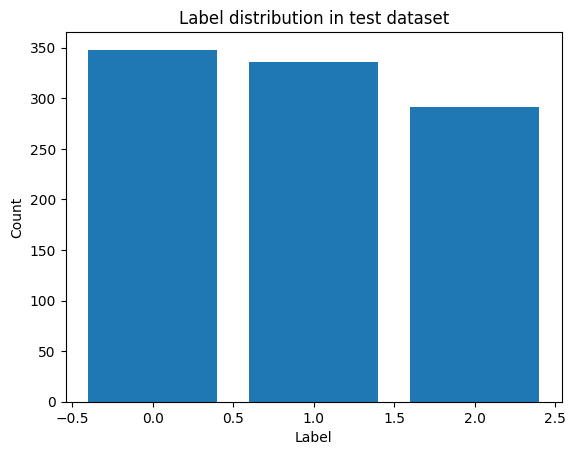

In [11]:
# show label distribution in dataset['test']
import matplotlib.pyplot as plt
import numpy as np

labels = dataset['test']['label']
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.title('Label distribution in test dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [31]:
bucket.download_file('dlr/my_best_tapelegen_model.zip', 'model.zip')

# extreact zip file to data folder
!rm -r model
!unzip model.zip -d model

rm: cannot remove 'model': No such file or directory
Archive:  model.zip
   creating: model/my_best_tapelegen_model/
  inflating: model/my_best_tapelegen_model/training_args.bin  
  inflating: model/my_best_tapelegen_model/config.json  
  inflating: model/my_best_tapelegen_model/pytorch_model.bin  
  inflating: model/my_best_tapelegen_model/preprocessor_config.json  


In [15]:
!pip install transformers==4.26.1 evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [16]:
import transformers

checkpoint = "./model/my_best_tapelegen_model"

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    checkpoint
)
print(feature_extractor.size)
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

{'height': 224, 'width': 224}
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


/home/ray/anaconda3/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
from torchvision import transforms
import numpy as np

def preprocess(image):
    # convert image to tensor
    tensor = transforms.ToTensor()(image)
    tensor = tensor - np.mean(tensor.numpy()) + 128
    tensor[tensor < 0] = 0
    tensor[tensor > 255] = 255
    tensor = tensor / 255
    # repeat the tensor two ore times to get 3 channels and use the repeat function
    tensor = tensor.repeat(3, 1, 1)
    return tensor


class Preprocess:
    def __init__(self):
        self.transforms = transforms.Compose(
            [
                transforms.Lambda(preprocess),
                transforms.CenterCrop(224),
            ]
        )

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [
            self.transforms(img) for img in example_batch["image"]
        ]
        del example_batch["image"]
        return example_batch
    
preprocessed_dataset = dataset.with_transform(Preprocess())

In [20]:
labels = dataset['test'].features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [21]:
id2label

{'0': 'g', '1': 'n', '2': 'o'}

In [22]:
label2id

{'g': '0', 'n': '1', 'o': '2'}

In [23]:
labelids = [int(id) for id in id2label.keys()]

In [24]:

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

In [25]:

from transformers import TrainingArguments

batch_size = 14*16

training_args = TrainingArguments(
    output_dir="my_tapelegen_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


In [26]:
import evaluate
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [27]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [28]:
model.to('cuda')

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validate"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [33]:
prediction = trainer.predict(preprocessed_dataset["test"])

***** Running Prediction *****
  Num examples = 975
  Batch size = 672
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [56]:
predicted_labels = np.argmax(prediction.predictions, axis=1)

In [57]:
actual_labels = dataset["test"][:]["label"]

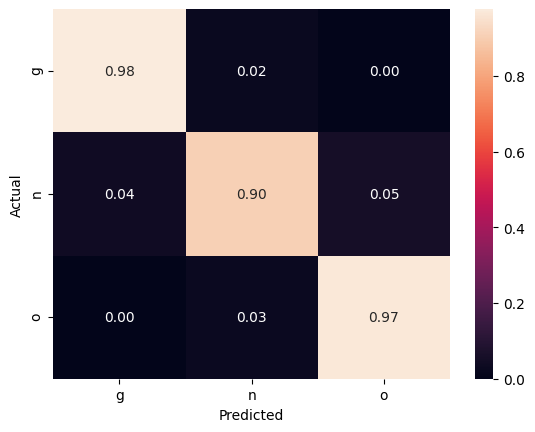

In [58]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual_labels, predicted_labels, labels=labelids)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
